<a href="https://colab.research.google.com/github/herrcult69/HME-Recognition-DSAI/blob/main/HME_recognition_ColabVersion_10423041.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ntcuong2103_crohme2019_path = kagglehub.dataset_download('ntcuong2103/crohme2019')

print('Data source import complete.')


Data source import complete.


In [ ]:
# If it is failed, run the above cell again to fix
assert ntcuong2103_crohme2019_path == "/kaggle/input/crohme2019"


## **CROHME Temporal Sequence Classification (CROHME-CTC) Baseline**

In this project, we will build and train a recurrent neural network (RNN) for translating handwritten mathematical expressions into sequence of symbols and relations based on Symbol Relation Tree and CROHME dataset.

The model we'll be using is a simple RNN with a single layer of Bidirectional LSTM cells. We will use Connectionist Temporal Classification (CTC) loss to train the model.

The model is trained on the CROHME dataset, which contains handwritten mathematical expressions in the form of Symbol Relation Trees. The dataset is preprocessed and converted into a sequence of symbols and relations, which is used as the input to the model.

Your job is to feature engineer the input data and train the model to achieve the best performance possible. Additionally, consider implementing data augmentation techniques to enhance the training dataset.

Some features from the project:

*   Public competition dataset: CROHME https://paperswithcode.com/dataset/crohme-2019
*   Advance data preparation: time series feature extraction, collate function
*   High level API of pytorch lightning
*   Experiment tracking with Weight and Biases



## Dependencies

In [ ]:
!pip -q install pytorch-lightning torchmetrics wandb
# Install required packages for CUDA CTC Decoder
!pip install torchaudio
!pip install flashlight-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics.text import EditDistance


import numpy as np
import pandas as pd
import os

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb

import xml.etree.ElementTree as ET
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from helper import *
from collections.abc import Sequence
from typing import Literal, Optional, Union

import json
# Add these imports to your import section
import torchaudio
from torchaudio.models.decoder import ctc_decoder

In [ ]:
# mount crohme2019 -> dataset
!ln -s /kaggle/input/crohme2019 dataset

> The above command created a symbolic link
> dataset -> /kaggle/input/crohme2019
>
> We can now access the dataset from current directory instead of /kaggle/input

In [ ]:
# This code for displaying current directory tree, you don't need to run.

!sudo apt-get install tree
!tree -L 3 dataset

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (62.8 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 126319 files and directories currently instal

### Overview of the dataset

This is the folder structure of the dataset.

```
dataset
├── crohme2019
│   └── crohme2019
│       ├── test
│       ├── train
│       └── valid
├── crohme2019_test.txt
├── crohme2019_train.txt
└── crohme2019_valid.txt
```

There are two parts:
* Inkml files: XML based files containing handwriting data (sequences of handwritten strokes) captured from the devices.
```
dataset
├── crohme2019
│   └── crohme2019
│       ├── test
│       ├── train
│       └── valid
```
* Annotation files: Containing the labels for each input handwriting samples.
```
dataset
├── crohme2019_test.txt
├── crohme2019_train.txt
└── crohme2019_valid.txt
```


> An example of inkml file, the points (x, y coords) are recorded in each trace (handwritten stroke).

```
<ink xmlns="http://www.w3.org/2003/InkML">
<traceFormat>
<channel name="X" type="decimal"/>
<channel name="Y" type="decimal"/>
</traceFormat>
...

<trace id="0">
241 123, 240 123, 239 123, 238 123, 237 123, 236 123, 236 122, 237 122, 238 122, 240 122, 242 122, 244 122, 247 122, 251 121, 254 121, 257 121, 260 120, 262 120, 265 120, 266 120, 267 120, 268 120, 269 120, 268 120
</trace>
<trace id="1">
301 123, 300 124, 299 124, 298 124, 297 124, 296 124, 295 124, 294 124, 295 124, 296 124, 297 124, 298 124, 299 123, 301 123, 302 123, 303 123, 304 122, 305 122, 306 122, 307 122, 308 122, 310 122, 311 122, 314 122, 316 121, 317 121, 319 121, 321 121, 323 121, 328 120, 330 120, 332 120, 333 120, 335 120, 336 120, 344 119, 346 119, 348 119, 350 119, 352 119, 357 119, 358 119, 360 119, 362 119, 364 119, 365 119, 370 119, 372 119, 373 119, 374 119, 375 119, 377 119, 377 118, 376 118, 374 118, 372 118
</trace>
<trace id="2">
318 89, 319 89, 320 89, 321 88, 323 87, 324 86, 325 84, 326 83, 327 82, 328 80, 329 79, 330 77, 331 75, 332 74, 333 73, 333 72, 333 73, 333 75, 333 76, 333 78, 333 80, 332 81, 332 83, 332 85, 332 86, 332 88, 332 90, 332 92, 332 93, 333 95, 333 97, 333 98, 333 100, 333 101, 333 102, 333 103, 333 104, 333 103, 333 101, 332 99
</trace>
<trace id="3">
302 148, 301 148, 302 147, 302 146, 303 145, 304 144, 305 143, 306 142, 307 140, 308 139, 308 138, 308 137, 308 136, 308 137, 308 138, 309 139, 309 140, 309 141, 309 142, 309 144, 309 146, 309 147, 309 149, 309 151, 309 153, 309 155, 309 157, 310 159, 310 162, 310 164, 310 169, 310 171, 310 172, 310 174, 311 175, 311 179, 311 180, 311 181, 311 182, 311 181
</trace>
...

</ink>

```

> An example of annotation file: left part is inkml file path, right part is the label (target) for that inkml file.

```
...
crohme2019/test/UN19_1041_em_597.inkml	- Right \sqrt Inside 2
crohme2019/test/UN19_1019_em_256.inkml	a Right n Right y
crohme2019/test/UN19_1033_em_474.inkml	V Sub n Right - Right 1 NoRel = Right \int Right d Sup n Right - Right 1 NoRel x Right \sqrt Inside h

...
```

> The label is a sequence of **symbols** and **spatial relations** between symbols (based on writing order).



## Task 1: Build Vocabulary

Builds and manages a vocabulary for converting characters (tokens) to indices (encoding) and vice-versa (decoding). This is essential for processing text data in machine learning tasks, particularly for sequence-to-sequence models like those used in handwriting recognition or mathematical expression translation.

In this project, the vocabulary is for encoding the target sequence (for example: "- Right \\sqrt Inside 2") into a sequence of indices ([5, 37, 74, 30, 10]). It is constructed from multiple annotation files (train, test, and validation sets) and includes a special blank character (this is for CTC loss). It supports encoding (tokens to indices) and decoding (indices to tokens) operations.


> _You will need to build the `class Vocab` using the two functions provided. Also the vocabulary should be exported as a JSON file so that we can reuse it later in the dataset._

***Input***: the path to the dataset files _(train, valid, and test)_.


```python
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]
```

***Output***: the vocabulary.

```python
vocab = {
    "a": 0,
    "b": 1,
    "c": 2,
    ...
}
```

In [ ]:
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]

df = pd.read_csv(paths[1], sep="\t", header=None, names=["path", "label"]).dropna().astype(str)

df.head()

,path,label
0,crohme2019/test/UN19_1032_em_455.inkml,4 Right n Right - Right 4 Right ) NoRel ( NoRe...
1,crohme2019/test/UN19_1044_em_632.inkml,\phi Sub 0 NoRel = Right d Right x Sup 1 Right...
2,crohme2019/test/UN19wb_1111_em_1039.inkml,9 Right \times Right 9 Right + Right 1 Right 3...
3,crohme2019/test/UN19_1028_em_394.inkml,\tan Right \alpha Right \tan Right \theta Sup ...
4,crohme2019/test/UN19_1005_em_64.inkml,a Right = NoRel 1 NoRel - Below \sqrt Inside 2...


In [ ]:
def get_unique_chars(paths) -> set:
    res = set()
    for i in df['label'].apply(lambda x: x.strip().split()):
        res.update(i)
    return res

len(get_unique_chars(paths[0]))

108

In [ ]:
unique_chars = get_unique_chars(paths[0])
unique_chars

{'!',
 '(',
 ')',
 '+',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'Above',
 'B',
 'Below',
 'C',
 'COMMA',
 'E',
 'F',
 'G',
 'H',
 'I',
 'Inside',
 'L',
 'M',
 'N',
 'NoRel',
 'P',
 'R',
 'Right',
 'S',
 'Sub',
 'Sup',
 'T',
 'V',
 'X',
 'Y',
 '[',
 '\\Delta',
 '\\alpha',
 '\\beta',
 '\\cos',
 '\\div',
 '\\exists',
 '\\forall',
 '\\gamma',
 '\\geq',
 '\\gt',
 '\\in',
 '\\infty',
 '\\int',
 '\\lambda',
 '\\ldots',
 '\\leq',
 '\\lim',
 '\\log',
 '\\lt',
 '\\mu',
 '\\neq',
 '\\phi',
 '\\pi',
 '\\pm',
 '\\prime',
 '\\rightarrow',
 '\\sigma',
 '\\sin',
 '\\sqrt',
 '\\sum',
 '\\tan',
 '\\theta',
 '\\times',
 '\\{',
 '\\}',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|'}

The vocabulary should be sorted by ascii table. The first character (index 0) must be blank (`''`).

In [ ]:
def chr2idx(unique_chars: set) -> dict:
    unique_chars.add('')
    return {char: idx for idx, char in enumerate(sorted(unique_chars))}

vocab = chr2idx(get_unique_chars(paths[0]))

assert vocab[""] == 0
assert vocab["|"] == 108
assert vocab["\\pi"] == 68
assert vocab["\\exists"] == 51
assert len(vocab) == 109

In [ ]:
class Vocab:
    """

    Attributes:
        paths (list): A list of file paths to the annotation files.
        char2idx (dict): A dictionary mapping characters to their corresponding indices.  This is the primary vocabulary.
        idx2char (dict): A reverse mapping from indices to characters, facilitating decoding.

    Methods:
        build_vocab(): Builds the vocabulary from the specified annotation files, sorting characters lexicographically and adding a blank character.
        get_vocab(): Returns the character-to-index vocabulary.
        save_vocab(path): Saves the vocabulary to a JSON file.
        encode(tokens): Converts a list of tokens (characters) into a list of their corresponding indices.
        decode(ids): Converts a list of indices back into a list of tokens (characters).
    """
    def __init__(self, vocab_file=None):
        self.char2idx = {}
        if vocab_file is not None:
            self.char2idx = json.load(open(vocab_file))
        self.idx2char = {v: k for k, v in self.char2idx.items()}

    def build_vocab(self, annotations) -> None:
        vocab = {}
        unique_tokens = set()

        for anno_files in annotations:
            with open(anno_files, 'r', encoding='utf-8') as file:
                for each_line in file:
                    splitted_line = each_line.strip().split('\t'); # Split the line into two parts the path and the label (sequence of nodes)
                    if len(splitted_line) >= 2:
                        sequence = splitted_line[1].strip() # Extract the sequence and split it into individual tokens
                        tokens =  sequence.split()
                        for token in tokens:
                            unique_tokens.add(token)

        sorted_tokens = sorted(list(unique_tokens))
        vocab = {'': 0}  # Set the blank/ empty string to 0

        # Assign each token to indices starting from 1
        for idx, char in enumerate(sorted_tokens, start=1):
            vocab[char] = idx

        # Assign vocab to the class
        self.char2idx = vocab

    def get_vocab(self) -> dict:  # getter
        return self.char2idx

    def save_vocab(self, path: str) -> None:  # save vocab to json file
        with open(path, 'w') as f:
            json.dump(self.char2idx, f)

    def encode(self, tokens):
        return [self.char2idx[token] for token in tokens]

    def decode(self, ids):
        return [self.idx2char[id] for id in ids]


In [ ]:
# CHECKPOINT: build vocab from annotations
annotations = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]

vocab = Vocab()
vocab.build_vocab(annotations)
vocab.save_vocab('vocab.json')

In [ ]:
# TEST: vocab class loaded from prebuilt JSON
vocab = Vocab('vocab.json')

# encoding a sequence
input = '- Right \\sqrt Inside 2'.split()

assert vocab.encode(input) == [5, 37, 74, 30, 10]
assert vocab.decode(vocab.encode(input)) == input

## Task 2: Build Dataset

In this task, we will build a dataset class that will be used to load the dataset files _(train, valid, and test)_.

The dataset class will also be used to preprocess the data by converting the characters in the data to integers using the vocabulary.

> _Before going to this task, it is **highly recommended** to read this [Tutorial on creating Custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) with PyTorch._
>
> _You should have basic understanding of required methods in the Dataset class such as `__init__`, `__len__`, and `__getitem__`._


***Input***: Dataset class should take the following arguments:.

- `annotation`: the path to the dataset annotation *(`.txt`)*.
- `root_dir`: the root directory of the dataset file.
- `vocab`: the vocabulary.

***Output***: the dataset class.

> *Note: You can adjust the Dataset class base on your references.*


### Dataflow
Below is a typical dataflow to train a model.
```mermaid
flowchart LR
    A[Raw Data] --> |parse| B[Cleaned Data]
    B --> |feature engineering| C[Dataset]
    C --> |package| D[DataLoader]
    D --> |load| E[Model]
    E --> |predict| F[Output]
    F --> |calculate| G[Loss]
    G --> |backpropagate| E
```

### Handling Inkml files

We have an inkml file: `crohme2019/test/UN19_1041_em_597.inkml`

Its label is `- Right \sqrt Inside 2`

Target would be: `[5, 37, 74, 30, 10]`, where the index here is the index of tokens (from a vocabulary)

We provided you with class `Inkml` to handle the parsing and processing of the inkml files. The main method you will use is `getTraces()` which returns the traces of the inkml file.

> _Inspect this class and understand how you should be working with this type of data._

```python

In [ ]:
class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""

    __slots__ = ("id", "label", "strId")

    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])


class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""

    __slots__ = ("fileName", "strokes", "strkOrder", "segments", "truth", "UI")

    NS = {
        "ns": "http://www.w3.org/2003/InkML",
        "xml": "http://www.w3.org/XML/1998/namespace",
    }

    def __init__(self, *args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()

    def fixNS(self, ns, att):
        """Build the right tag or element name with namespace"""
        return "{" + Inkml.NS[ns] + "}" + att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall("ns:annotation", namespaces=Inkml.NS):
            if "type" in info.attrib:
                if info.attrib["type"] == "truth":
                    self.truth = info.text.strip()
                if info.attrib["type"] == "UI":
                    self.UI = info.text.strip()
        for strk in root.findall("ns:trace", namespaces=Inkml.NS):
            self.strokes[strk.attrib["id"]] = strk.text.strip()
            self.strkOrder.append(strk.attrib["id"])
        segments = root.find("ns:traceGroup", namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in segments.iterfind("ns:traceGroup", namespaces=Inkml.NS):
            id = seg.attrib[self.fixNS("xml", "id")]
            label = seg.find("ns:annotation", namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall("ns:traceView", namespaces=Inkml.NS):
                strkList.add(t.attrib["traceDataRef"])
            self.segments[id] = Segment(id, label, strkList)

    def getTraces(self, height=256):
        traces_array = [
            np.array(
                [p.strip().split() for p in self.strokes[id].split(",")], dtype="float"
            )
            for id in self.strkOrder
        ]

        ratio = height / (
            (
                np.concatenate(traces_array, 0).max(0)
                - np.concatenate(traces_array, 0).min(0)
            )[1]
            + 1e-6
        )
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

    def view(self):
        plt.figure(figsize = (16, 4))
        plt.axis("off")
        for trace in self.getTraces():
            trace_arr = np.array(trace)
            plt.plot(trace_arr[:, 0], -trace_arr[:, 1])  # invert y coordinate

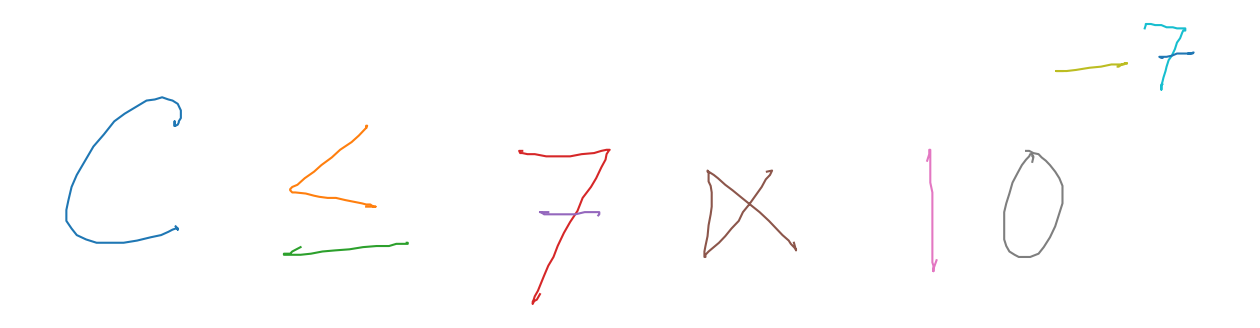

In [ ]:
inkml_path = '/content/dataset/crohme2019/crohme2019/test/ISICal19_1202_em_771.inkml'
ink = Inkml(inkml_path)
ink.view()

In [ ]:
# Display shapes of first 5 traces in one file

[np.array(trace).shape for trace in ink.getTraces()][:20]

[(46, 2),
 (32, 2),
 (22, 2),
 (39, 2),
 (17, 2),
 (47, 2),
 (24, 2),
 (39, 2),
 (18, 2),
 (32, 2),
 (14, 2)]

> **REMARK**: _Some Inkml may return (x, y, t) coordinates, while most of them return (x, y) coordinates. Make sure to handle this inconsistency in your implementation._

### Build Dataset

For calculating the Connectionist Temporal Classification (CTC) loss, read the [expected output](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) of this loss function from PyTorch.

> _Hint: focus on the shapes and the expected variables. (see code example for calculating loss)_
> ```python
> loss = ctc_loss(input_tensor, target_tensor, input_lengths, target_lengths)
> ```

**Base on the observation, how can we build a dataset class from the dataset files?**

> Hints:
>   - *Understand the big picture. (Dataflow)*
>   - *What informations needed to calculate our Loss?*
>   - *What should be returned in the `__getitem__` method?*
>   - *The outputs should be of Tensor type*
   
***References from pytorch [tutorials](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)***

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.

- `__getitem__` to support the indexing such that `dataset[i]` can be used to get ith sample.


### Feature representation

In this task, we will convert the strokes into feature representations that can be used by the model.

Initially, the `.getTraces()` method returns list of strokes, where each stroke is a list of (x, y) coordinates. Intuitively, we can use those coordinates as features. But if directly using the coordinates as features, the model will have a hard time learning the patterns.

Instead, we can calculate the difference *(∆d)* between consecutive coordinates as features. This way, the model can learn the patterns more easily.

$\Delta_x = x_{i+1} - x_i$ and $\Delta_y = y_{i+1} - y_i$

The feature would then be normalized as

($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$), where $d = \sqrt{\Delta_x^2 + \Delta_y^2}$

**Pen-up and Pen-down**

In the dataset, each stroke is separated by a pen-up event. We can use this information to separate the strokes.

1. The pen is lifted from the paper (connecting the end of a stroke to the start of a stroke): $pen\_up = 1$
2. The pen is on the paper: $pen\_up = 0$

Then, our feature representation would be:
($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$, $d$, $pen\_up$)


```
point 1: (x1, y1)
point 2: (x2, y2)
point 3: (x3, y3) <--- end of stroke #1
point 4: (x4, y4) <--- start of stroke #2
...
point n: (xn, yn)
```

The feature representation will be:

```
f1 = ((x2 - x1) / d, (y2 - y1)/d, d, 0)
f2 = ((x3 - x2) / d, (y3 - y2)/d, d, 0)
f3 = ((x4 - x3) / d, (y4 - y3)/d, d, 1) <-- pen up
...
fn-1 = ((xn - xn-1) / d, (yn - yn-1)/d, d, 0)
```

#### **CHECK LIST**

For each data sample, we will do the following steps
- Combine all the strokes into a single stroke (N, 2)
- Compute first order differences of x and y coordinates
- Remove any zero length strokes
- Compute Euclidean distances between consecutive points
- Normalize the x and y coordinates by Euclidean distance
- Add feature pen-up/pen-down
> *Features of transformed data: (delta traces, distance, pen_up_down)*

Label
- Define label (list of indices of the words)

Finally, we will convert the data and label to PyTorch tensors.
- Convert data and label to PyTorch tensors

In [ ]:
class InkmlDataset(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file txt.
            root_dir (string): directory holds the dataset.
            vocab (set): of vocab.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab

        # load annotations
        self.inks = []
        self.labels = []
        # Parse annotation file
        self._load_annotations()

    def _load_annotations(self):
        """Load and parse annotation file"""
        try:
            with open(self.annotation, 'r', encoding='utf-8') as file:
                lines = file.readlines()

            for line in lines:
                line = line.strip()
                if not line:  # Skip empty lines
                    continue

                parts = line.split('\t', 1)  # Split only on first tab
                if len(parts) == 2:
                    relative_path, label_text = parts
                    full_path = os.path.join(self.root_dir, relative_path.strip())
                    self.inks.append(full_path)
                    self.labels.append(label_text.strip())

        except FileNotFoundError:
            raise FileNotFoundError(f"Annotation file not found: {self.annotation}")

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Return the idx-th sample in the dataset"""

        # Get paths and labels
        ink_file_path = self.inks[idx]
        target_label = self.labels[idx]

        # Load inkml file
        inkml_obj = Inkml(ink_file_path)
        stroke_list = inkml_obj.getTraces()


        feature_sequence = self._extract_features(stroke_list)

        # Convert to tensors
        input_tensor = torch.tensor(feature_sequence, dtype=torch.float32)
        input_length = torch.tensor(len(feature_sequence), dtype=torch.long)

        # Process labels
        target_tokens = target_label.split()
        encoded_targets = self.vocab.encode(target_tokens)
        target_tensor = torch.tensor(encoded_targets, dtype=torch.long)
        target_length = torch.tensor(len(encoded_targets), dtype=torch.long)

        return input_tensor, target_tensor, input_length, target_length

    def _extract_features(self, strokes):
        all_features = []
        previous_point = None
        current_stroke_idx = -1

        for stroke_number, current_stroke in enumerate(strokes):
            for point in current_stroke:
                # Handle both (x,y) and (x,y,t)
                if len(point) >= 2:
                    x_coord, y_coord = float(point[0]), float(point[1])
                else:
                    continue  # skip other points

                if previous_point is None:
                    previous_point = (x_coord, y_coord)
                    current_stroke_idx = stroke_number
                    continue

                d_x = x_coord - previous_point[0]
                d_y = y_coord - previous_point[1]
                euclidean_dist = (d_x**2 + d_y**2)**0.5

                # Skip if no movement
                if euclidean_dist < 1e-6: # small epsilon instead of 0
                    continue

                #normalize
                normalized_dx = d_x / euclidean_dist
                normalized_dy = d_y / euclidean_dist

                is_pen_up = 1 if stroke_number > current_stroke_idx else 0

                #feature vector
                feature_vector = [normalized_dx, normalized_dy, euclidean_dist, is_pen_up]
                all_features.append(feature_vector)

                # Update state
                previous_point = (x_coord, y_coord)
                current_stroke_idx = stroke_number

        return all_features

## Task 3: Build Lightning Data Module via Dataloader

Revise [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) to see how you can prepare your data for training with DataLoader.

Then refer to this [documentation](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) to understand how DataLoader in PyTorch loads Batched or Non-Batched data.

> **TASK:** Write the dataloader with custom collate function to pad the input and target sequence

For a better understanding of the importance of handling variable-length sequences in deep learning models, it is crucial to format and pad the data appropriately to ensure consistency during training. Learn more about this topic [here](https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3).

> _**Hint 1**: use `torch.nn.utils.rnn.pad_sequence` to pad the input and target sequences. Read more about this function [here](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html)._

> _**Hint 2**: read Example 3 from this [tutorial](https://www.programiz.com/python-programming/methods/built-in/zip) to unpack data using `zip()`._

In [ ]:
def collate_fn(batch):
    """Create batch"""
    input_tensors, target_tensors, input_lengths, target_lengths = zip(*batch)
    features = pad_sequence(input_tensors, batch_first=True, padding_value=0.0)

    # Pad
    labels = pad_sequence(target_tensors, batch_first=True, padding_value=0)

    input_lens = torch.stack(input_lengths)
    label_lens = torch.stack(target_lengths)

    return features, labels, input_lens, label_lens

In [ ]:
vocab = Vocab('vocab.json')
dataset = InkmlDataset(annotation="dataset/crohme2019_test.txt", root_dir="dataset/crohme2019", vocab=vocab)
features, labels, input_lens, label_lens = collate_fn([dataset[0], dataset[1]])

import numpy.testing as npt

assert type(input_lens) == torch.Tensor
assert type(label_lens) == torch.Tensor
assert type(features) == torch.Tensor
assert type(labels) == torch.Tensor

# print(f"Features shape: {features.shape}")
# print(f"Labels shape: {labels.shape}")
# print(f"Input lengths: {input_lens}")
# print(f"Label lengths: {label_lens}")

> **TASK:** implement InkmlDataset_PL Lightning Datamodule

In [ ]:
class InkmlDataset_PL(pl.LightningDataModule):
    """
    PyTorch Lightning data module for handling the INKML dataset.
    """

    def __init__(
        self,
        batch_size: int = 10,
        num_workers: int = 4,
        train_annotation: str = "",
        validation_annotation: str = "",
        test_annotation: str = "",
        root_dir: str = "dataset",
        vocab_file: str = "vocab.json"
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_annotation = train_annotation
        self.val_annotation = validation_annotation
        self.test_annotation = test_annotation
        self.root_dir = root_dir
        self.vocab_file = vocab_file

    def setup(self, stage=None):
        # Load vocabulary
        vocab = Vocab(self.vocab_file)

        if stage == "fit" or stage is None:
            self.train_dataset = InkmlDataset(
                self.train_annotation,
                root_dir=self.root_dir,
                vocab=vocab
            )
            self.val_dataset = InkmlDataset(
                self.val_annotation,
                root_dir=self.root_dir,
                vocab=vocab
            )
        if stage == "test" or stage is None:
            self.test_dataset = InkmlDataset(
                self.test_annotation,
                root_dir=self.root_dir,
                vocab=vocab
            )

    def custom_collate_fn(self, batch):
        """Custom collate function for variable-length sequences"""
        # Unpack batch
        input_tensors, target_tensors, input_lengths, target_lengths = zip(*batch)

        # Pad sequences
        padded_traces = pad_sequence(input_tensors, batch_first=True, padding_value=0.0)
        padded_labels = pad_sequence(target_tensors, batch_first=True, padding_value=0)

        # Stack lengths
        len_traces = torch.stack(input_lengths)
        len_labels = torch.stack(target_lengths)

        return padded_traces, padded_labels, len_traces, len_labels

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.custom_collate_fn,
            shuffle=True  # Added shuffle for training
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.custom_collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.custom_collate_fn,
        )

## Task 4: Build Model

In this task, we will build a model that will be used to train the dataset.
The model will be a simple RNN with a single layer of Bidirectional LSTM cells. The model will take the input from the dataset and output the predicted sequence of symbols and relations and will use CTC loss to train the model.

The model will be built using PyTorch and will use the following architecture


> _We highly recommend you to read through this [tutorial on Creating a model using Pytorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html) and understand the basic building blocks of a model in PyTorch._

> _**ATTENTION** Below is the architecture for the model. You must **STRICTLY** follow the architecture and the parameters mentioned below._
> | Layer Type         | Configuration                              |
> |--------------------|--------------------------------------------|
> | Input              | Sequence of vectors with `input_size=4`    |
> | LSTM Layer         | `hidden_size=256`, `num_layers=2`          |
> |                    | `batch_first=True`                         |
> |                    | `bidirectional=True`                       |
> | LSTM Output        | Output shape: `(batch_size, seq_len, hidden_size*2)`|
> | Fully Connected    | `Linear(hidden_size*2, num_classes)`|
> | Activation         | `LogSoftmax(dim=...)`|
> | Output             | `(batch_size, seq_len, num_classes)`|


In [ ]:
class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_TemporalClassification, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, # 4 features
            hidden_size=hidden_size, # 256
            num_layers=num_layers, # 2 layers
            batch_first=True, # Input shape: (batch, seq, features)
            bidirectional=True # Forward + backward = 2*hidden_size output
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_out = self.fc(lstm_out)
        output = self.log_softmax(fc_out)
        return output

In [ ]:
# Test your implementation
model = LSTM_TemporalClassification(4, 256, 2, 109)
assert model.forward(torch.rand((10, 100, 4))).shape == (10, 100, 109)

## Task 5: Understand CTC Loss

In this task, we will understand how to use CTC loss to train the model. The CTC loss is used to train the model to predict the sequence of symbols and relations from the input sequence of features.

> _For deeper understanding of CTC loss, read this [blog](https://distill.pub/2017/ctc/)_

Check out this [Pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) to learn more about its implementation.

> _Hint: read the expected input and output of the CTC loss function. The input should be of shape `(T, N, C)` where T is the length of the input sequence, N is the batch size, and C is the number of classes. The target should be of shape `(N, S)` where S is the length of the target sequence._

After understanding how CTC Loss works, we can proceed to implement it in our model.

In [ ]:
# From task 9: This was added to make the run easier
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = vocab.char2idx[""]
    def forward(self, emission: torch.Tensor) -> list:

        # Get the best path (indices with highest probability at each timestep)
        indices = torch.argmax(emission, dim=-1)

        # Remove nearby duplicates
        collapsed_indices = []
        previous_idx = None

        for idx in indices:
            idx_item = idx.item()
            if idx_item != previous_idx:  # only add if different from previous
                collapsed_indices.append(idx_item)
                previous_idx = idx_item

        # Remove blanks
        filtered_indices = [idx for idx in collapsed_indices if idx != self.blank]

        #Convert indices back to tokens using vocabulary
        output_seq_list = self.vocab.decode(filtered_indices)

        return output_seq_list

In [ ]:
# From task 10: this was added to make the run easier
def edit_distance(predicted_sequence, label_sequence):

    len_pred = len(predicted_sequence)
    len_label = len(label_sequence)

    distance_grid = [[0] * (len_label + 1) for _ in range(len_pred + 1)]
    for j in range(len_label + 1):
        distance_grid[0][j] = j

    for i in range(len_pred + 1):
        distance_grid[i][0] = i

    for i in range(1, len_pred + 1):
        for j in range(1, len_label + 1):
            sub_cost = 0 if predicted_sequence[i - 1] == label_sequence[j - 1] else 1
            delete_cost = distance_grid[i - 1][j] + 1
            insert_cost = distance_grid[i][j - 1] + 1
            substitution_path_cost = distance_grid[i - 1][j - 1] + sub_cost

            distance_grid[i][j] = min(delete_cost, insert_cost, substitution_path_cost)

    return distance_grid[len_pred][len_label]


## Task 6: Build Lightning Module

In this task, we will build a Lightning module that will be used to train the model. The Lightning module will mostly be used to define the training and validation steps, as well as the optimizer and learning rate scheduler.

> _More on building Lightning module can be found [here](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html). You should read about core methods to know what to implement in your module._

In [ ]:
def categorize_tokens(vocab):
    """Categorize tokens into symbols and relations"""
    relations = {
        'Right', 'Left', 'Above', 'Below', 'Sub', 'Sup', 'Inside', 'NoRel'
    }

    symbols = set()
    relation_tokens = set()

    for token in vocab.char2idx.keys():
        if token == '':  # blank token
            continue
        elif token in relations:
            relation_tokens.add(token)
        else:
            symbols.add(token)

    return symbols, relation_tokens

def calculate_separate_wer(predicted_tokens, ground_truth_tokens, vocab):
    """Calculate WER separately for symbols and relations"""
    symbols, relations = categorize_tokens(vocab)

    # Separate predicted tokens
    pred_symbols = [token for token in predicted_tokens if token in symbols]
    pred_relations = [token for token in predicted_tokens if token in relations]

    # Separate ground truth tokens
    gt_symbols = [token for token in ground_truth_tokens if token in symbols]
    gt_relations = [token for token in ground_truth_tokens if token in relations]

    # Calculate edit distances
    symbol_edit_dist = edit_distance(pred_symbols, gt_symbols)
    relation_edit_dist = edit_distance(pred_relations, gt_relations)

    # Calculate WERs
    symbol_wer = symbol_edit_dist / len(gt_symbols) if len(gt_symbols) > 0 else 0.0
    relation_wer = relation_edit_dist / len(gt_relations) if len(gt_relations) > 0 else 0.0

    return symbol_wer, relation_wer

In [ ]:
class MathOnlineModel(pl.LightningModule):
    def __init__(
        self,
        lr=0.001,
        input_size=4,
        output_size=109,
        hidden_size=256,
        num_layers=2,
        decoder=None,
        constraint_weight=0.1,
        lr_scheduler_patience=5,
        lr_scheduler_factor=0.1,
        monitor_metric="val_wer",
        use_cuda_decoder=True,  # NEW: Option to use CUDA decoder
        beam_size=10  # NEW: Beam size for CUDA decoder
    ):
        self.save_hyperparameters()
        super().__init__()

        self.model = LSTM_TemporalClassification(
            input_size, hidden_size, num_layers, output_size
        )
        self.criterion = nn.CTCLoss(
            blank=0,
            reduction='mean',
            zero_infinity=True
        )
        self.lr = lr
        self.constraint_weight = constraint_weight

        # Initialize decoder
        if decoder is None:
            vocab = Vocab('vocab.json')
            if use_cuda_decoder:
                self.decoder = CUDACTCDecoder(vocab, beam_size=beam_size)
                print("✓ Using CUDA CTC Decoder")
            else:
                self.decoder = GreedyCTCDecoder(vocab)
                print("✓ Using Greedy CTC Decoder")
        else:
            self.decoder = decoder

        self.relation_indices = self._get_relation_indices()
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor
        self.monitor_metric = monitor_metric


    def forward(self, x):
        return self.model(x)
    def _get_relation_indices(self):
        """Get indices of relation tokens in vocabulary"""
        relations = {'Right', 'Left', 'Above', 'Below', 'Sub', 'Sup', 'Inside', 'NoRel'}
        vocab = self.decoder.vocab
        relation_indices = []

        for token, idx in vocab.char2idx.items():
            if token in relations:
                relation_indices.append(idx)

        return torch.tensor(relation_indices, dtype=torch.long)
    def _calculate_constraint_loss(self, log_probs, input_features, input_lengths):
        batch_size, seq_len, num_classes = log_probs.shape
        device = log_probs.device

        # Move relation indices to correct device
        relation_indices = self.relation_indices.to(device)
        total_constraint_loss = 0.0

        for i in range(batch_size):
            try:
                actual_len = input_lengths[i].item()

                if actual_len <= 0 or actual_len > seq_len:
                    continue

                pen_up_states = input_features[i, :actual_len, 3]
                pen_down_mask = (pen_up_states == 0).float()

                # Check for NaN in input features
                if torch.isnan(pen_down_mask).any():
                    print(f"NaN detected in pen_down_mask for batch {i}")
                    continue

                log_probs_sample = log_probs[i, :actual_len, :]

                if torch.isnan(log_probs_sample).any():
                    print(f"NaN detected in log_probs for batch {i}")
                    continue

                log_probs_clamped = torch.clamp(log_probs_sample, min=-50, max=50)
                probs = torch.exp(log_probs_clamped)

                # Get relation probabilities
                if len(relation_indices) > 0:
                    relation_probs = probs[:, relation_indices]
                    p_rel = torch.sum(relation_probs, dim=1)
                else:
                    p_rel = torch.zeros(actual_len, device=device)

                constraint_term = torch.sum(p_rel * pen_down_mask)

                # Clamp
                constraint_term = torch.clamp(constraint_term, min=0.0, max=actual_len)

                # Add epsilon and clamp the argument to log
                eps = 1e-8
                log_arg = torch.clamp(1.0 - constraint_term + eps, min=eps, max=1.0)
                constraint_loss = -torch.log(log_arg)

                # Final NaN check
                if torch.isnan(constraint_loss) or torch.isinf(constraint_loss):
                    print(f"Invalid constraint_loss for batch {i}: {constraint_loss}")
                    constraint_loss = torch.tensor(0.0, device=device)

                total_constraint_loss += constraint_loss

            except Exception as e:
                print(f"Error in constraint loss calculation for batch {i}: {e}")
                continue

        # Return safe constraint loss
        if batch_size > 0:
            final_loss = total_constraint_loss / batch_size
        else:
            final_loss = torch.tensor(0.0, device=device)

        return final_loss

    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        log_probs = self.forward(x)
        log_probs_ctc = log_probs.transpose(0, 1)  # (seq_len, batch_size, num_classes)

        ctc_loss = self.criterion(
            log_probs=log_probs_ctc,
            targets=y,
            input_lengths=x_lens,
            target_lengths=y_lens
        )
        constraint_loss = self._calculate_constraint_loss(log_probs, x, x_lens)
        total_loss = ctc_loss + self.constraint_weight * constraint_loss
        wer, wer_sym, wer_rel = self._calculate_wer(log_probs, y, x_lens, y_lens)

        # Log learning rate
        lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=True, on_epoch=False, prog_bar=False)

        self.log("train_loss", total_loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_ctc_loss", ctc_loss, prog_bar=False, on_step=True, on_epoch=True)
        self.log("train_constraint_loss", constraint_loss, prog_bar=False, on_step=True, on_epoch=True)
        self.log("train_wer", wer, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_wer_sym", wer_sym, prog_bar=False, on_step=False, on_epoch=True)
        self.log("train_wer_rel", wer_rel, prog_bar=False, on_step=False, on_epoch=True)

        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        log_probs = self.forward(x)
        log_probs_ctc = log_probs.transpose(0, 1)
        ctc_loss = self.criterion(
            log_probs=log_probs_ctc,
            targets=y,
            input_lengths=x_lens,
            target_lengths=y_lens
        )


        constraint_loss = self._calculate_constraint_loss(log_probs, x, x_lens)
        total_loss = ctc_loss + self.constraint_weight * constraint_loss
        wer, wer_sym, wer_rel = self._calculate_wer(log_probs, y, x_lens, y_lens)

        # Log metrics
        self.log("val_loss", total_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_ctc_loss", ctc_loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log("val_constraint_loss", constraint_loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log("val_wer", wer, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_wer_sym", wer_sym, prog_bar=False, on_step=False, on_epoch=True)
        self.log("val_wer_rel", wer_rel, prog_bar=False, on_step=False, on_epoch=True)

        return total_loss


    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch

        # Forward pass
        log_probs = self.forward(x) # Shape: (batch=16, seq_len, 109)

        # Create separate variable for CTC loss
        log_probs_ctc = log_probs.transpose(0, 1) # Shape: (seq_len, batch=16, 109)

        # CTC Loss calculation
        loss = self.criterion(
            log_probs=log_probs_ctc,
            targets=y,
            input_lengths=x_lens,
            target_lengths=y_lens
        )

        # WER calculation
        wer, wer_sym, wer_rel = self._calculate_wer(log_probs, y, x_lens, y_lens)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_wer", wer, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_wer_sym", wer_sym, prog_bar=False, on_step=False, on_epoch=True)
        self.log("test_wer_rel", wer_rel, prog_bar=False, on_step=False, on_epoch=True)

        return loss

    def _calculate_wer(self, log_probs, targets, input_lengths, target_lengths):
        batch_size = log_probs.size(0)
        total_edit_distance = 0
        total_target_length = 0
        total_symbol_edit_distance = 0
        total_symbol_length = 0
        total_relation_edit_distance = 0
        total_relation_length = 0

        for i in range(batch_size):
            # Get predictions for this sample
            sample_log_probs = log_probs[i, :input_lengths[i], :]

            # Decode predictions
            try:
                predicted_tokens = self.decoder.forward(sample_log_probs)
            except Exception:
                predicted_tokens = []

            # Get ground truth tokens
            target_tokens = targets[i, :target_lengths[i]].tolist()

            # Convert target indices to tokens using vocab
            try:
                vocab = self.decoder.vocab
                ground_truth_tokens = vocab.decode(target_tokens)
            except Exception:
                ground_truth_tokens = []

            # Calculate overall edit distance
            edit_dist = edit_distance(predicted_tokens, ground_truth_tokens)
            total_edit_distance += edit_dist
            total_target_length += len(ground_truth_tokens)

            # Calculate separate WERs
            symbol_wer, relation_wer = calculate_separate_wer(
                predicted_tokens, ground_truth_tokens, vocab
            )

            # Track separate metrics
            symbols, relations = categorize_tokens(vocab)
            gt_symbols = [token for token in ground_truth_tokens if token in symbols]
            gt_relations = [token for token in ground_truth_tokens if token in relations]

            total_symbol_edit_distance += symbol_wer * len(gt_symbols)
            total_symbol_length += len(gt_symbols)
            total_relation_edit_distance += relation_wer * len(gt_relations)
            total_relation_length += len(gt_relations)

        # Calculate overall WER
        wer = total_edit_distance / total_target_length if total_target_length > 0 else 0.0

        # Calculate separate WERs
        wer_sym = total_symbol_edit_distance / total_symbol_length if total_symbol_length > 0 else 0.0
        wer_rel = total_relation_edit_distance / total_relation_length if total_relation_length > 0 else 0.0

        return wer, wer_sym, wer_rel

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr) # Use self.hparams.lr
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min', # 'min' for loss, 'max' for accuracy
            factor=self.hparams.lr_scheduler_factor, # Factor by which the learning rate will be reduced
            patience=self.hparams.lr_scheduler_patience, # Number of epochs with no improvement after which learning rate will be reduced
            verbose=True,
            min_lr=1e-7 # Minimum learning rate
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": self.hparams.monitor_metric, # Metric to monitor
                "interval": "epoch", # Check scheduler conditions every epoch
                "frequency": 1, # Check every 1 epoch
            },
        }

## Task 7: Train the Model with PyTorch Lightning

Read more about Training with PyTorch Lightning [here](https://lightning.ai/docs/pytorch/stable/common/trainer.html) and understand how to use the Trainer class to train the model.

From the documentation:

> The Lightning Trainer does much more than just “training”. Under the hood, it handles all loop details for you, some examples include:
> - Automatically enabling/disabling grads
> - Running the training, validation and test dataloaders
> - Calling the Callbacks at the appropriate times
> - Putting batches and computations on the correct devices

> **IMPORTANT**: You must config your WandB logger to log the training and validation metrics. Without this, your work will not be graded.

In [ ]:
student_id = "10423041"  # TODO: replace with your student ID
api_key = "2b821a6c6a9949625413bbb27b3f69453bc18b0a"  # configure your wandb key here

if api_key == "":
    raise ValueError("Please set your wandb key in the code or in the environment variable WANDB_API_KEY")
else:
    print("WandB API key is set. Proceeding with login...")

wandb.login(key=api_key)
vocab = Vocab('vocab.json')
decoder = GreedyCTCDecoder(vocab)

WandB API key is set. Proceeding with login...


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 10423041 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
lr = 0.002
hidden_size = 256
num_layer = 2
max_epochs = 15
batch_size = 16

wandb_logger = WandbLogger(
    entity="cuong-nt-vgu-ai-2025",  # DO NOT CHANGE THIS
    project="math_online_2025", # DO NOT CHANGE THIS
    name=f"{student_id}_run_herrcult69_SemiFinal",
    config={
        "student_id": student_id,  # DO NOT CHANGE THIS
        "model": "LSTM_TemporalClassification",
        # Architecture Hyperparameters
        "input_size": 4,
        "hidden_size": hidden_size,
        "num_layers": num_layer,
        "num_classes": 109,
        "bidirectional": True,

        # Training Hyperparameters
        "learning_rate": lr,
        "batch_size": batch_size,  # Start smaller for CTC convergence
        "max_epochs": max_epochs,
        "optimizer": "Adam",
        "weight_decay": 1e-4,

        # Data Hyperparameters
        "num_workers": 4,
        "pin_memory": True,

        # CTC Loss Hyperparameters
        "blank_token_idx": 0,
        "ctc_reduction": "mean",
        "zero_infinity": True,

        # WER log
        "monitor_metric": "val_wer"
    },
    log_model=True,
    save_dir="wandb_logs",
    reinit=True,
)

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),
        EarlyStopping(monitor='val_wer', min_delta=0.001, patience=8, verbose=True, mode='min', strict=True)
    ],
    logger = wandb_logger,
    check_val_every_n_epoch=1,
    fast_dev_run=True,  # enable for testing model
    default_root_dir='checkpoint',
    deterministic=False,
    max_epochs=max_epochs,
    log_every_n_steps=50,
    devices = "auto",
    gradient_clip_val=0.5,
    gradient_clip_algorithm="norm",
)
model = MathOnlineModel(lr=lr, hidden_size=hidden_size, num_layers=num_layer, constraint_weight=0.1)
# model = MathOnlineModel.load_from_checkpoint('/content/wandb_logs/math_online_2025/ovbz3id1/checkpoints/epoch=9-val_wer=0.1645.ckpt', lr = lr)

dm = InkmlDataset_PL(
    root_dir='dataset/crohme2019',
    train_annotation='dataset/crohme2019_train.txt',
    validation_annotation='dataset/crohme2019_valid.txt',
    test_annotation='dataset/crohme2019_test.txt',
    vocab_file='vocab.json',
    batch_size=batch_size,
    num_workers=8
)

try:
    trainer.fit(model, dm)
    print("Training completed successfully")
except Exception as e:
    print(f"Training failed: {e}")
    import traceback
    traceback.print_exc()
finally:
    wandb.finish()
    print("WandB run finished")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


NameError: name 'CUDACTCDecoder' is not defined

In [ ]:
wandb.finish()

**Requirements:**
- Validation loss (val_loss < 0.7)

**Tips on training:**
- Debug with **fast_dev_run**:
Before run the training process, it is better to make a quick check of training and validation loop. Set fast_dev_run=True, then run the trainer and check if there is any bug exist.
- Training initially with **small batch size**:
In practice, training with CTC loss converges slowly for large batch size. To accelerate convergence, training with small batch size first, save model, then, train with large batch size.
- Train more epochs by setting:

```python
trainer = Trainer(
    ...
    max_epochs=20,
    ...
)
```

## Task 8: Test your model

Run the test set and check the accuracy of your model. The test set is used to evaluate the performance of the model on unseen data.

In [ ]:
trainer = Trainer(
    devices=1,
    logger=False,  # Disable logging for testing
    enable_checkpointing=False,  # Disable checkpointing for testing
)
try:
    # Load the model from a checkpoint
    model = MathOnlineModel.load_from_checkpoint(
    "/content/wandb_logs/math_online_2025/skug9d31/checkpoints/epoch=2-val_wer=0.1118.ckpt",)
    print("✓ Model loaded successfully")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    print("Make sure you have a trained checkpoint file")


dm = InkmlDataset_PL(
    root_dir="dataset/crohme2019",
    train_annotation="",  # Empty for testing
    validation_annotation="",    # Empty for testing
    test_annotation="dataset/crohme2019_test.txt",  # Only test annotation needed
    vocab_file="vocab.json",
    batch_size=batch_size,
    num_workers=2  # Reduced for stability
)

# Step 5: Run the test
print("Starting model testing...")
try:
    test_results = trainer.test(model, datamodule=dm)
    print("✓ Testing completed successfully")
    print(f"Test results: {test_results}")
except Exception as e:
    print(f"✗ Error during testing: {e}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✓ Model loaded successfully
Starting model testing...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.527968168258667     │
│         test_wer          │    0.11174412071704865    │
│       test_wer_rel        │    0.0898263156414032     │
│       test_wer_sym        │    0.1302817016839981     │
└───────────────────────────┴───────────────────────────┘

✓ Testing completed successfully
Test results: [{'test_loss': 0.527968168258667, 'test_wer': 0.11174412071704865, 'test_wer_sym': 0.1302817016839981, 'test_wer_rel': 0.0898263156414032}]


## Task 9: Inference

The output of networks need to process by a decoding step.

- Greedy decode: Your task is to implement greedy decoding method. Which converts the output into a string of symbols and relations (same form with labels). Greedy decoder produce the best path by removing consecutive repeated symbols/relations and then remove \<blank\>

> **TASK**: Implement the greedy decoder for the model output.

Based on GreedyCTCDecoder class from this [link](https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html#greedy-decoder), write decoding for an output. Your implementation should handle the output of the model and convert it into a string of symbols and relations, ensuring to remove consecutive repeated symbols/relations and the blank token.

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = vocab.char2idx[""]  # Fixed: use char2idx instead of word2index

    def forward(self, emission: torch.Tensor) -> list:

        # Get the best path (indices with highest probability at each timestep)
        indices = torch.argmax(emission, dim=-1)  # Shape: [seq_len]

        # Remove consecutive duplicates
        collapsed_indices = []
        previous_idx = None

        for idx in indices:
            idx_item = idx.item()
            if idx_item != previous_idx:  # Only add if different from previous
                collapsed_indices.append(idx_item)
                previous_idx = idx_item

        # Remove blank tokens
        filtered_indices = [idx for idx in collapsed_indices if idx != self.blank]

        #Convert indices back to tokens using vocabulary
        output_seq_list = self.vocab.decode(filtered_indices)

        return output_seq_list

Then you can test the output of your model here

In [ ]:
def test_model(model_checkpoint_path):
    # Load trained model
    model = MathOnlineModel.load_from_checkpoint(model_checkpoint_path)
    model.eval()
    # Determine the device the model is on
    device = next(model.parameters()).device
    print(f"Model is on device: {device}")

    # Load vocabulary and dataset
    vocab = Vocab('vocab.json')
    dataset = InkmlDataset(
        annotation="dataset/crohme2019_test.txt",
        root_dir="dataset/crohme2019",
        vocab=vocab
    )

    # Create decoder
    greedy_decoder = GreedyCTCDecoder(vocab)
    cuda_ctc_decoder = CUDACTCDecoder(vocab)
    use_cuda = True

    # Get a sample
    feature, label, input_len, label_len = dataset[0]

    # Add batch dimension
    feature_batch = feature.unsqueeze(0)  # Shape: [1, seq_len, 4]
    feature_batch = feature_batch.to(device)
    # Model prediction
    with torch.no_grad():
        log_probs = model(feature_batch)  # Shape: [1, seq_len, num_classes]

        # Remove batch dimension for decoder
        emission = log_probs.squeeze(0)  # Shape: [seq_len, num_classes]

        # Decode
        if use_cuda:
            decoded_output = cuda_ctc_decoder.forward(emission)
        else:
            decoded_output = greedy_decoder.forward(emission)

    # Compare with ground truth
    ground_truth = vocab.decode(label.tolist())

    print(f"Ground truth: {ground_truth}")
    print(f"Predicted:    {decoded_output}")

    return decoded_output, ground_truth

# Example usage (uncomment when you have a trained model):
decoded, truth = test_model('/content/wandb_logs/math_online_2025/skug9d31/checkpoints/epoch=2-val_wer=0.1118.ckpt')



Model is on device: cuda:0
Ground truth: ['4', 'Right', 'n', 'Right', '-', 'Right', '4', 'Right', ')', 'NoRel', '(', 'NoRel', '-', 'NoRel', '2', 'Right', 'n', 'Right', '-', 'Right', '1', 'Right', ')', 'NoRel', '(', 'NoRel', '=', 'Right', '2', 'Right', 'n', 'Right', '-', 'Right', '3']
Predicted:    ['4', 'Sub', 'n', 'NoRel', '-', 'Right', '4', 'Right', ')', 'NoRel', '(', 'NoRel', '-', 'Right', '2', 'Right', 'n', 'Right', '-', 'Right', '1', 'Right', ')', 'NoRel', '(', 'NoRel', '=', 'Right', '2', 'Right', 'n', 'Right', '-', 'Right', '3']


## Task 10: Implement calculation metric for training

In [ ]:
def calculate_edit_distance(predicted_sequence, label_sequence):

    len_pred = len(predicted_sequence)
    len_label = len(label_sequence)

    distance_grid = [[0] * (len_label + 1) for _ in range(len_pred + 1)]
    for j in range(len_label + 1):
        distance_grid[0][j] = j

    for i in range(len_pred + 1):
        distance_grid[i][0] = i

    for i in range(1, len_pred + 1):
        for j in range(1, len_label + 1):
            sub_cost = 0 if predicted_sequence[i - 1] == label_sequence[j - 1] else 1
            delete_cost = distance_grid[i - 1][j] + 1
            insert_cost = distance_grid[i][j - 1] + 1
            substitution_path_cost = distance_grid[i - 1][j - 1] + sub_cost

            distance_grid[i][j] = min(delete_cost, insert_cost, substitution_path_cost)

    return distance_grid[len_pred][len_label]
# Test your implementation
assert (
    edit_distance(
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "0",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "\\phi",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
    )
    == 1
)

> **TASK**: Implement word error rate metric (wer) for training,  validation and testing in your model.
>
> $wer = \frac{total\ edit\ distance (predict\ sequence,\ target\ sequence)}{total\ target\ sequence\ length}$


**Steps to process:**

- Decode the predicted sequences to obtain the text output.
- Calculate the total edit distance between the predicted and target sequences.
- Compute the word error rate using the formula provided.
- Log the WER metric during training and validation.

**Continue to train the model**

- Load the latest trained model:

```
model = MathOnlineModel.load_from_checkpoint('path/to/your/checkpoint.ckpt')
```
- Change config of ModelCheckPoint to monitor the new metric (val_wer) instead.

```
        ModelCheckpoint(filename='{epoch}-{val_loss:.4f}', save_top_k=5, monitor='val_loss', mode='min')
        
      --> ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),

```


Model is on device: cpu
Decoded Predicted Sequence: a Right \neq Right - Right 5
Ground Truth Sequence: a Right \neq Right - Right b


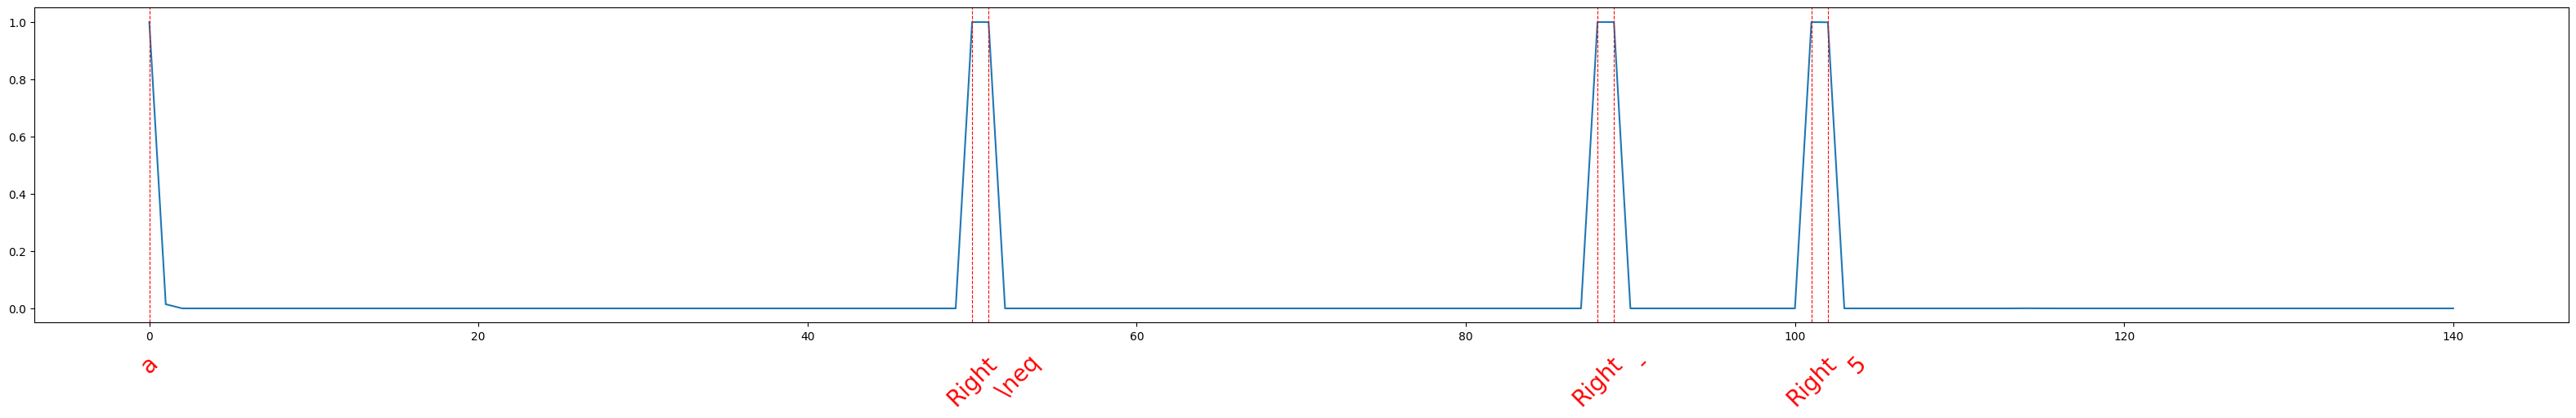

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_model_prediction(model, dataset, sample_idx=0, vocab_file='vocab.json'):

    model.eval()
    # Determine the device the model is on
    device = next(model.parameters()).device
    print(f"Model is on device: {device}")


    vocab = Vocab(vocab_file)

    feature, label, _, _ = dataset[sample_idx]
    feature_batch = feature.unsqueeze(0).to(device)

    with torch.no_grad():
        log_probs = model(feature_batch)
        probs = torch.exp(log_probs).squeeze(0).cpu().numpy()

    blank_id = 0
    non_blank_probs = 1 - probs[:, blank_id]

    decoder = GreedyCTCDecoder(vocab)
    predicted_tokens_final = decoder.forward(log_probs.squeeze(0))
    ground_truth_tokens = vocab.decode(label.tolist())

    seq_len = probs.shape[0]
    timesteps = np.arange(seq_len)

    predicted_indices = np.argmax(probs, axis=1)

    label_positions = []
    label_texts = []
    last_idx = -1

    for i, current_idx in enumerate(predicted_indices):
        if current_idx != blank_id and current_idx != last_idx:
            label_positions.append(i)
            try:
                token = vocab.decode([current_idx])[0]
            except Exception:
                token = '?'

            if len(token) > 8:
                token = token[:6] + '..'
            label_texts.append(token)
        last_idx = current_idx

    # --- Plot Creation ---
    fig, ax = plt.subplots(1, 1, figsize=(40, 5))

    # Plot the non-blank probability line
    ax.plot(timesteps, non_blank_probs, label='Non-Blank Probability')
    # Fill the area under the curve
    # ax.fill_between(timesteps, 0, non_blank_probs, alpha=0.3)

    # Set x-axis ticks and labels based on predicted tokens
    for pos in label_positions:
        ax.axvline(x=pos, color='red', linestyle='--', linewidth=0.8)

    # 3. Place text with collision avoidance
    # Determines minimum separation between labels in data coordinates. Tune as needed.
    min_x_separation = 0.02 * seq_len
    last_text_x = -np.inf # Keep track of the last label's position

    # Get a good y-position below the axis for the labels
    y_pos_text = ax.get_ylim()[0] - 0.1

    for pos, text in zip(label_positions, label_texts):
        # Nudge the text position to the right if it's too close to the previous one
        text_x = max(pos, last_text_x + min_x_separation)

        ax.text(text_x, y_pos_text, text,
                ha='center', # Horizontal alignment
                va='top',    # Vertical alignment
                rotation=45,
                color="red",
                fontsize=20)
        last_text_x = text_x

    # --- Print Final Results ---
    print(f"Decoded Predicted Sequence: {' '.join(predicted_tokens_final)}")
    print(f"Ground Truth Sequence: {' '.join(ground_truth_tokens)}")


def test_visualization():
    model_path = '/content/epoch=2-val_wer=0.1118.ckpt'
    model = MathOnlineModel.load_from_checkpoint(model_path)
    model.cpu()

    # Load dataset
    vocab = Vocab('vocab.json')
    dataset = InkmlDataset(
        annotation="dataset/crohme2019_test.txt",
        root_dir="dataset/crohme2019",
        vocab=vocab
    )

    visualize_model_prediction(model, dataset, sample_idx=77)
# Run the visualization
test_visualization()

In [ ]:
# Bonus 4
class CUDACTCDecoder:
    def __init__(self, vocab, beam_size=10):
        self.vocab = vocab
        self.beam_size = beam_size
        self.blank_id = vocab.char2idx[""]
        self.greedy_decoder = GreedyCTCDecoder(vocab)

        # Create tokens list (vocabulary without blank)
        self.tokens = []
        for idx in range(len(vocab.char2idx)):
            if idx != self.blank_id:
                token = vocab.decode([idx])[0]
                self.tokens.append(token)

        # Initialize the CUDA CTC decoder
        try:
            self.decoder = ctc_decoder(
                lexicon=None,  # No lexicon for mathematical expressions
                tokens=self.tokens,
                lm=None,
                nbest=1,  # Return best hypothesis
                beam_size=self.beam_size,
                blank_token="",
                sil_token="",
                unk_word="<unk>",
                log_add=False,
            )
            print("CUDA CTC Decoder initialized successfully")
        except Exception as e:
            print(f"Failed to initialize CUDA CTC Decoder: {e}")
            print("Falling back to Greedy decoder...")
            self.decoder = None

    def decode(self, log_probs):
        if self.decoder is None:
            # Fallback to greedy decoding
            log_probs_2d = log_probs.squeeze(0) if log_probs.dim() == 3 else log_probs
            return self._greedy_decode(log_probs_2d)

        try:
            if log_probs.dim() == 2:
                # Add batch dimension: [seq_len, num_classes] -> [1, seq_len, num_classes]
                log_probs = log_probs.unsqueeze(0)

            # Move to CPU if on GPU
            log_probs_cpu = log_probs.cpu()
            beam_results = self.decoder(log_probs_cpu)

            # Extract best hypothesis
            if beam_results and len(beam_results[0]) > 0:
                best_result = beam_results[0][0]  # First batch, first hypothesis
                decoded_tokens = best_result.tokens
                return decoded_tokens
            else:
                return []

        except Exception as e:
            print(f"CUDA CTC Decoder failed: {e}")
            print("Falling back to greedy decoder...")
            return self._greedy_decode(log_probs.squeeze(0) if log_probs.dim() == 3 else log_probs)

    def _greedy_decode(self, log_probs):
        return self.greedy_decoder(log_probs)

    def forward(self, emission):
        return self.decode(emission)

Created 108 clean tokens for CUDA decoder
Blank token (index 0) excluded from CUDA tokens
✗ Fixed CUDA decoder failed: get_index(): incompatible function arguments. The following argument types are supported:
    1. (self: flashlight.lib.text.flashlight_lib_text_dictionary.Dictionary, entry: str) -> int

Invoked with: <flashlight.lib.text.flashlight_lib_text_dictionary.Dictionary object at 0x7f6a22dabab0>, None


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


=== CUDA CTC Decoder Test ===
Ground truth: ['4', 'Right', 'n', 'Right', '-', 'Right', '4', 'Right', ')', 'NoRel', '(', 'NoRel', '-', 'NoRel', '2', 'Right', 'n', 'Right', '-', 'Right', '1', 'Right', ')', 'NoRel', '(', 'NoRel', '=', 'Right', '2', 'Right', 'n', 'Right', '-', 'Right', '3']
CUDA decoded: ['4', 'Sub', 'n', 'NoRel', '-', 'Right', '4', 'Right', ')', 'NoRel', '(', 'NoRel', '-', 'Right', '2', 'Right', 'n', 'Right', '-', 'Right', '1', 'Right', ')', 'NoRel', '(', 'NoRel', '=', 'Right', '2', 'Right', 'n', 'Right', '-', 'Right', '3']
WER: 0.0857


=== Vocabulary Inspection ===
Total tokens: 109
Blank token at index 0: ''

Special LaTeX tokens (35):
  46: '\Delta'
  47: '\alpha'
  48: '\beta'
  49: '\cos'
  50: '\div'
  51: '\exists'
  52: '\forall'
  53: '\gamma'
  54: '\geq'
  55: '\gt'


## **BONUS TASKS**

The following tasks are optional and can be done for extra credit to the final exam.

### **Bonus 1**: Add metric to evaluate accuracy of symbols and relations seperately *(+0.5pt)*

**Add the metrics: wer for symbols and wer for relations**
```
self.log('wer_sym',...)
self.log('wer_rel',...)
```

### **Bonus 2**: Modify loss function to constraint the output of relations at the time step of pen-up *(+1pt)*
Modify loss function to constrain the output of relations at the timestep of pen-up.

The idea: Provide a masked sequence such that the position of pen-up is masked, the additional loss would penaltize all the relations output to the timestep that has been masked.


**Loss function to constraint relation output**

```
pen_down: a masked sequence, where len(pen_down) = len(input_sequence)
        and pen_down[t] == 1 (pen down), pen_down[t] == 0 (pen up)
p_rel: total probability of relation outputs for every time step t, len(p_rel) = len(input_sequence), p_rel[t] = sum(p[t][rel] for rel in ['Sub', 'Sup', 'Above', ...])

The loss is defined as:

    L_{constraint} = -log(1 - sum(p_rel * pen_down))
    
Explanation:

    Minimize L_{constraint} (value range of (-inf, 0)) would make maximize of (1 - sum(p_rel * pen_down)), or making sum(p_rel * mask) -> 0, then it will penalize the relation output on pen_down timesteps.
```

**Apply constraint loss function with ctc loss**

```
    L = loss_{ctc} + \lambda * L_{constraint}
    
where \lambda is a weighted parameter to control balance between the two losses.
   
```


You can also find it in a published paper here, section 3.4:
https://arxiv.org/pdf/2105.10156

### **Bonus 3**: Visualize model prediction by timesteps and probability of softmax outputs *(+0.5pt)*

![alt text](https://github.com/fuisl/crohme-ctc/blob/6722b97ec2000afcd16068220f0b1b83b3134ff8/assets/graph_with_prob.png?raw=true)

### **Bonus 4**: Use CUDA CTC Decoder to optimize decoding process in model *(+0.5pt)*

Follow the instructions via this [link](https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html#cuda-ctc-decoder) to implement CUDA CTC decoder in your model.